In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip -q install -U transformers datasets accelerate peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 137.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 55.5 MB/s eta 0:00:00


Imports

In [3]:
import os
import time
import re
import json
import random
import copy
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from transformers import BlipProcessor, BlipForQuestionAnswering
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

Randomness + Device

In [4]:
SEED = 42

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
g = torch.Generator()
g.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Drive Paths

In [5]:
AML_ROOT = "/content/drive/MyDrive/AML_code"
os.makedirs(AML_ROOT, exist_ok=True)

PROJECT_NAME = "AML"
PROJECT_DIR  = os.path.join(AML_ROOT, PROJECT_NAME)
os.makedirs(PROJECT_DIR, exist_ok=True)

# checkpoints root
CKPT_DIR = os.path.join(PROJECT_DIR, "checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

# BLIP checkpoints
BLIP_BASELINE_DIR     = os.path.join(CKPT_DIR, "blip_baseline")
BLIP_AUG_BASELINE_DIR = os.path.join(CKPT_DIR, "blip_aug_baseline")
BLIP_AUG_LORA_DIR     = os.path.join(CKPT_DIR, "blip_aug_lora")

# Classical model checkpoints
CLASSIFICATION_CKPT_DIR = os.path.join(CKPT_DIR, "classification")
os.makedirs(CLASSIFICATION_CKPT_DIR, exist_ok=True)

# outputs
METRICS_JSON_PATH = os.path.join(PROJECT_DIR, "metrics_all.json")
RESULTS_CSV_PATH  = os.path.join(PROJECT_DIR, "results_table.csv")

Load Data (HuggingFace VQA-RAD)

In [6]:
ds = load_dataset("flaviagiammarino/vqa-rad")
train_split = ds["train"]
test_split  = ds["test"]

print("Train:", len(train_split), "Test:", len(test_split))
print("Keys:", train_split[0].keys())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-eb8844602202be(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e5bc3d208bb4dee(…):   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

Train: 1793 Test: 451
Keys: dict_keys(['image', 'question', 'answer'])


EDA

Question: what type of image is this?
Answer: x-ray


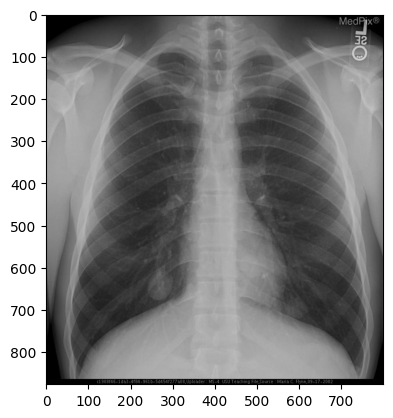

In [7]:
# Sample data
sample = train_split[78]
print('Question:', sample['question'])
plt.imshow(sample['image'].convert('RGB'))
print('Answer:', sample['answer'])

Question: are there >5 lymph nodes located near the stomach?
Answer: yes


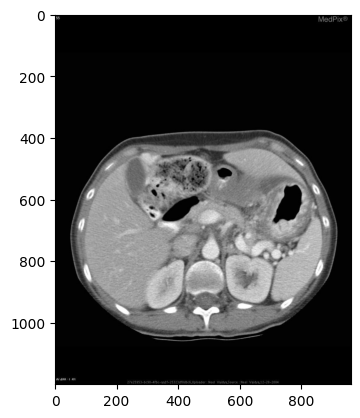

In [8]:
# Example of closed-ended question
sample = train_split[80]
print('Question:', sample['question'])
plt.imshow(sample['image'].convert('RGB'))
print('Answer:', sample['answer'])

Question: what is meant by tram-track?
Answer: thickening of bronchi


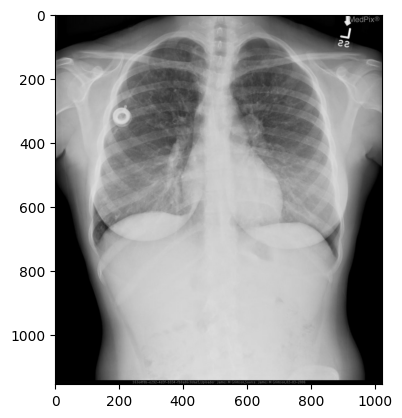

In [9]:
# Example of open-ended question
sample = train_split[683]
print('Question:', sample['question'])
plt.imshow(sample['image'].convert('RGB'))
print('Answer:', sample['answer'])

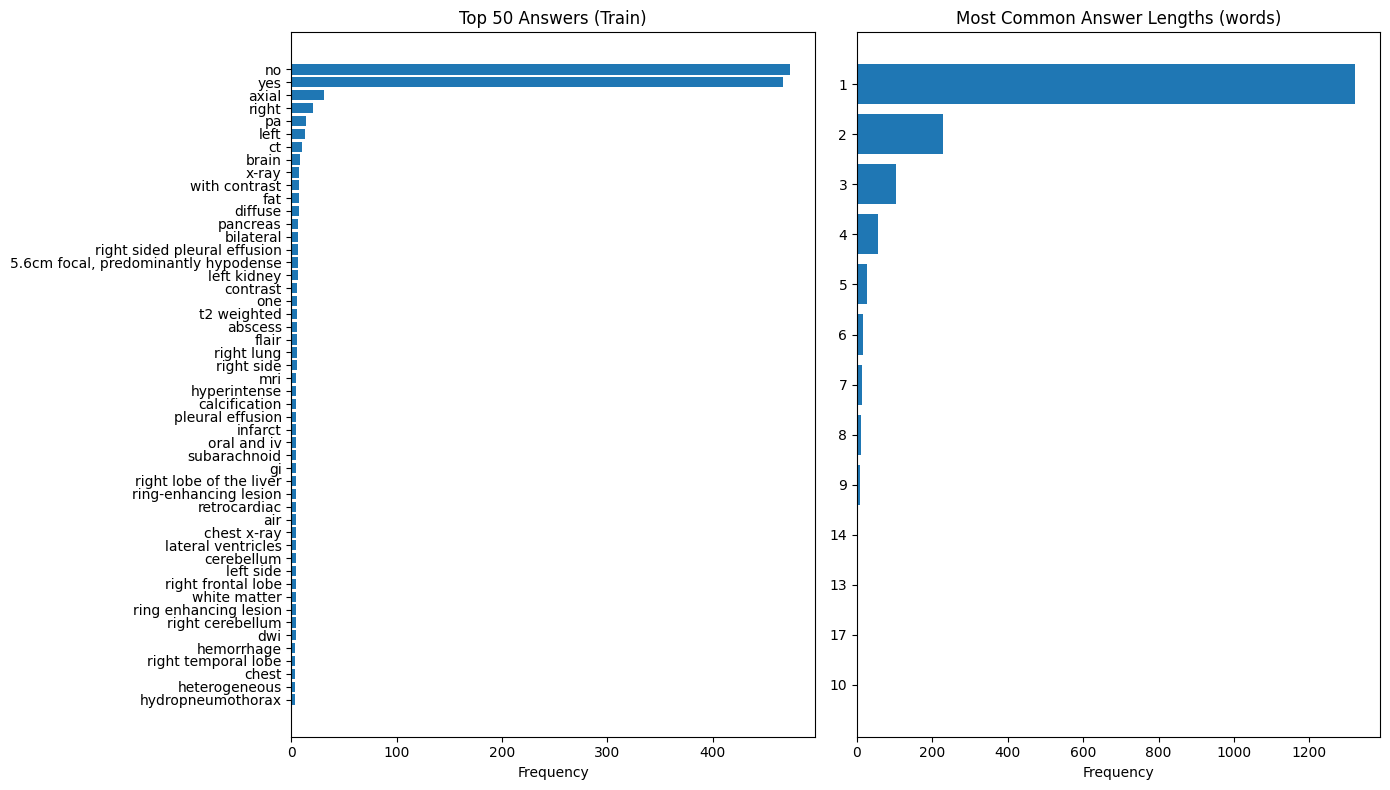

In [10]:
answers = [s["answer"] for s in train_split]
ans_counter = Counter(answers)

# Answer length counts
ans_lengths = [len(a.split()) for a in answers]
len_counter = Counter(ans_lengths)

top50_ans = ans_counter.most_common(50)
ans_labels, ans_counts = zip(*top50_ans)

top_len = sorted(len_counter.items(), key=lambda x: x[1], reverse=True)[:50]  # if fewer than 50, it just shows all
len_labels, len_counts = zip(*top_len)

plt.figure(figsize=(14, 8))

# subplot 1: top 50 answers
plt.subplot(1, 2, 1)
plt.barh(range(len(ans_labels)), ans_counts)
plt.yticks(range(len(ans_labels)), ans_labels)
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.title("Top 50 Answers (Train)")

# subplot 2: most common answer lengths
plt.subplot(1, 2, 2)
plt.barh(range(len(len_labels)), len_counts)
plt.yticks(range(len(len_labels)), [str(x) for x in len_labels])
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.title("Most Common Answer Lengths (words)")

plt.tight_layout()
plt.show()

Closed vs Open Split Rule

In [11]:
CLOSED_SET = {"yes", "no"}
def is_closed_ended(answer: str):
    return answer.lower() in CLOSED_SET

# quick counts (train)
closed_n = sum(is_closed_ended(s["answer"]) for s in train_split)
open_n = len(train_split) - closed_n
print("Train closed:", closed_n, "Train open:", open_n)

Train closed: 940 Train open: 853


Image Preprocessing + Augmentation

In [12]:
# Base transform (no augmentation)
image_transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

# Aug transform
image_transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.90, 1.0)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

# For BLIP
blip_pil_base = transforms.Compose([
    transforms.Resize((224, 224)),
])

blip_pil_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.90, 1.0)),
    transforms.RandomRotation(10),
])

Metrics: Closed Accuracy + Open BLEU-1 with Critical Attribute Match

In [13]:
def normalize_text(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9 ]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def bleu1(reference: str, hypothesis: str) -> float:
    ref = normalize_text(reference).split()
    hyp = normalize_text(hypothesis).split()
    if len(hyp) == 0:
        return 0.0

    ref_cnt = Counter(ref)
    hyp_cnt = Counter(hyp)

    matches = sum(min(hyp_cnt[w], ref_cnt.get(w, 0)) for w in hyp_cnt)
    precision = matches / len(hyp)

    r, c = len(ref), len(hyp)
    bp = 1.0 if c >= r else float(np.exp(1 - r / max(c, 1)))
    return bp * precision

# Critical attributes
ABBR = {"lt": "left", "rt": "right", "l": "left", "r": "right"}
LATERALITY = {"left", "right", "bilateral"}
NEGATION   = {"no", "not", "absent", "negative", "none", "without"}

def norm_tokens(s: str):
    toks = normalize_text(s).split()
    toks = [ABBR.get(t, t) for t in toks]
    return toks

def extract_critical(tokens):
    tset = set(tokens)
    return {
        "laterality": tset & LATERALITY,
        "negation":   tset & NEGATION,
    }

def critical_attribute_match(gt: str, pr: str) -> bool:
    gt_t = norm_tokens(gt)
    pr_t = norm_tokens(pr)
    gt_c = extract_critical(gt_t)
    pr_c = extract_critical(pr_t)

    # Enforce only if GT contains that critical attribute
    if gt_c["laterality"] and (gt_c["laterality"] != pr_c["laterality"]):
        return False
    if gt_c["negation"] and (gt_c["negation"] != pr_c["negation"]):
        return False
    return True

def bleu1_critical_gated(gt: str, pr: str) -> float:
    return bleu1(gt, pr) if critical_attribute_match(gt, pr) else 0.0

def eval_closed_open(gt_answers, pred_answers):
    """
    Closed-ended: exact normalized match (yes/no)
    Open-ended: BLEU-1 gated by critical attribute match (Option A)
    Also returns plain open_bleu1 (optional, for reference).
    """
    closed_correct = 0
    closed_total = 0

    open_bleu_sum = 0.0
    open_bleu_gated_sum = 0.0
    open_total = 0

    for gt, pr in zip(gt_answers, pred_answers):
        if is_closed_ended(gt):
            closed_total += 1
            if normalize_text(gt) == normalize_text(pr):
                closed_correct += 1
        else:
            open_total += 1
            open_bleu_sum += bleu1(gt, pr)
            open_bleu_gated_sum += bleu1_critical_gated(gt, pr)

    return {
        "closed_acc": closed_correct / max(closed_total, 1),
        "open_bleu1": open_bleu_sum / max(open_total, 1),
        "open_bleu1_crit": open_bleu_gated_sum / max(open_total, 1),
        "closed_n": closed_total,
        "open_n": open_total
    }

Saving/loading Metrics

In [14]:
def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def load_json(path):
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

Text Preprocessing (tokenize, vocab, encode)

In [15]:
def tokenize(text: str):
    text = text.lower().strip()
    return re.findall(r"[a-z0-9]+", text)

def build_vocab(questions, min_freq=1):
    counter = Counter()
    for q in questions:
        counter.update(tokenize(q))

    stoi = {"<pad>": 0, "<unk>": 1}
    for w, f in counter.items():
        if f >= min_freq and w not in stoi:
            stoi[w] = len(stoi)

    itos = {i: s for s, i in stoi.items()}
    return stoi, itos

def encode_question(q: str, stoi, max_len=20):
    ids = [stoi.get(t, stoi["<unk>"]) for t in tokenize(q)][:max_len]
    ids += [stoi["<pad>"]] * (max_len - len(ids))
    return torch.tensor(ids, dtype=torch.long)

train_questions = [s["question"] for s in train_split]
stoi, itos = build_vocab(train_questions, min_freq=1)
vocab_size = len(stoi)

Answer Space (Classification labels)

In [16]:
all_answers = [s["answer"] for s in train_split] + [s["answer"] for s in test_split]
unique_answers = sorted(set(all_answers))

answer2idx = {a: i for i, a in enumerate(unique_answers)}
idx2answer = {i: a for a, i in answer2idx.items()}
num_answers = len(answer2idx)

Dataset + DataLoaders

In [18]:
# Classical
class VQADataset(Dataset):
    def __init__(self, split, transform, max_q_len=20):
        self.ds = split
        self.transform = transform
        self.max_q_len = max_q_len

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        s = self.ds[idx]
        image = self.transform(s["image"])
        q_ids = encode_question(s["question"], stoi, self.max_q_len)
        gt_ans = s["answer"]
        y = torch.tensor(answer2idx[gt_ans], dtype=torch.long)
        return image, q_ids, y, gt_ans

batch_size = 16
train_loader = DataLoader(VQADataset(train_split, image_transform_base), batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(VQADataset(test_split,  image_transform_base), batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
train_loader_aug = DataLoader(VQADataset(train_split, image_transform_aug), batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# BLIP
class VQARadBLIPDataset(Dataset):
    def __init__(self, split, processor, pil_transform=None, max_q_len=32, max_a_len=16):
        self.ds = split
        self.processor = processor
        self.pil_transform = pil_transform
        self.max_q_len = max_q_len
        self.max_a_len = max_a_len

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        s = self.ds[idx]
        image = s["image"].convert("RGB")
        if self.pil_transform is not None:
            image = self.pil_transform(image)

        question = s["question"]
        answer = s["answer"]

        enc = self.processor(
            images=image,
            text=question,
            padding="max_length",
            truncation=True,
            max_length=self.max_q_len,
            return_tensors="pt"
        )

        tok = self.processor.tokenizer(
            answer,
            padding="max_length",
            truncation=True,
            max_length=self.max_a_len,
            return_tensors="pt"
        )

        decoder_input_ids = tok.input_ids  # keep PAD ids here (valid token ids)
        labels = decoder_input_ids.clone()
        pad_id = self.processor.tokenizer.pad_token_id
        labels[labels == pad_id] = -100     # mask PAD for loss only

        enc = {k: v.squeeze(0) for k, v in enc.items()}
        enc["decoder_input_ids"] = decoder_input_ids.squeeze(0)
        enc["labels"] = labels.squeeze(0)
        enc["gt_answer"] = answer
        return enc

def make_blip(model_name="Salesforce/blip-vqa-base"):
    processor = BlipProcessor.from_pretrained(model_name)
    model = BlipForQuestionAnswering.from_pretrained(model_name).to(device)
    return processor, model

BLIP_BATCH = 4
blip_processor_base, blip_model_base = make_blip("Salesforce/blip-vqa-base")
blip_train_loader = DataLoader(
    VQARadBLIPDataset(train_split, blip_processor_base, pil_transform=blip_pil_base),
    batch_size=BLIP_BATCH,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
blip_train_loader_aug = DataLoader(
    VQARadBLIPDataset(train_split, blip_processor_base, pil_transform=blip_pil_aug),
    batch_size=BLIP_BATCH,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
blip_test_loader = DataLoader(
    VQARadBLIPDataset(test_split, blip_processor_base, pil_transform=blip_pil_base),
    batch_size=BLIP_BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

Classical Model Components (CNN encoder + LSTM encoder)

In [19]:
class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # feature map before avgpool/fc: (B, 2048, 7, 7)
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.out_dim = 2048

    def forward(self, x):
        fmap = self.features(x)                # (B,C,H,W)
        vec = self.pool(fmap).flatten(1)       # (B,C)
        return vec, fmap

class LSTMEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, hidden=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True)
        self.out_dim = hidden

    def forward(self, q_ids):
        emb = self.embedding(q_ids)
        _, (h, _) = self.lstm(emb)
        return h[-1]  # (B, hidden)

# Stacking (Concat Fusion)
class VQA_Concat(nn.Module):
    def __init__(self, img_enc, txt_enc, num_answers):
        super().__init__()
        self.img_enc = img_enc
        self.txt_enc = txt_enc
        fusion_dim = img_enc.out_dim + txt_enc.out_dim
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_answers)
        )

    def forward(self, images, q_ids):
        img_vec, _ = self.img_enc(images)
        q_vec = self.txt_enc(q_ids)
        fused = torch.cat([img_vec, q_vec], dim=1)
        return self.classifier(fused)

# MCB Pooling
class CountSketch(nn.Module):
    def __init__(self, in_dim, out_dim, seed=123):
        super().__init__()
        g = torch.Generator()
        g.manual_seed(seed)

        h = torch.randint(low=0, high=out_dim, size=(in_dim,), generator=g)
        s = torch.randint(low=0, high=2, size=(in_dim,), generator=g) * 2 - 1  # +/-1

        self.register_buffer("h", h)
        self.register_buffer("s", s)
        self.in_dim = in_dim
        self.out_dim = out_dim

    def forward(self, x):
        # x: (B, in_dim)
        B, D = x.shape
        out = x.new_zeros((B, self.out_dim))
        # add signed values into hashed bins
        out.scatter_add_(1, self.h.unsqueeze(0).expand(B, -1), x * self.s.unsqueeze(0))
        return out

class MCBFusion(nn.Module):
    def __init__(self, img_dim, txt_dim, mcb_dim=8000):
        super().__init__()
        self.cs_img = CountSketch(img_dim, mcb_dim, seed=1)
        self.cs_txt = CountSketch(txt_dim, mcb_dim, seed=2)
        self.mcb_dim = mcb_dim

    def forward(self, img_vec, txt_vec):
        # CountSketch
        a = self.cs_img(img_vec)  # (B,m)
        b = self.cs_txt(txt_vec)  # (B,m)

        # FFT -> multiply -> iFFT
        fa = torch.fft.rfft(a, dim=1)
        fb = torch.fft.rfft(b, dim=1)
        f = fa * fb
        out = torch.fft.irfft(f, n=self.mcb_dim, dim=1)

        # signed sqrt + l2 norm (common in bilinear pooling)
        out = torch.sign(out) * torch.sqrt(torch.abs(out) + 1e-8)
        out = F.normalize(out, dim=1)
        return out

class VQA_MCB(nn.Module):
    def __init__(self, img_enc, txt_enc, num_answers, mcb_dim=8000):
        super().__init__()
        self.img_enc = img_enc
        self.txt_enc = txt_enc
        self.mcb = MCBFusion(img_enc.out_dim, txt_enc.out_dim, mcb_dim=mcb_dim)
        self.classifier = nn.Sequential(
            nn.Linear(mcb_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_answers)
        )

    def forward(self, images, q_ids):
        img_vec, _ = self.img_enc(images)
        q_vec = self.txt_enc(q_ids)
        fused = self.mcb(img_vec, q_vec)
        return self.classifier(fused)

# Cross-attention Fusion
class VQA_CrossAttention(nn.Module):
    def __init__(self, img_enc, vocab_size, num_answers,
                 embed_dim=300, lstm_hidden=512, max_q_len=20,
                 d_model=512, n_heads=8, dropout=0.1):
        super().__init__()
        self.img_enc = img_enc
        self.max_q_len = max_q_len

        # ---- Question token encoder (keeps token outputs) ----
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden, batch_first=True, bidirectional=False)

        # Project both modalities into the same d_model
        self.q_proj = nn.Linear(lstm_hidden, d_model)

        # CNN feature map is (B, C=2048, 7, 7) -> tokens (B, 49, 2048)
        self.img_proj = nn.Linear(img_enc.out_dim, d_model)

        # ---- Cross-attention block (Transformer-style) ----
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads,
                                                dropout=dropout, batch_first=True)

        self.ln1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(d_model)

        # Classifier on pooled question representation
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_answers),
        )

    def forward(self, images, q_ids):
        # ---- Image tokens ----
        _, fmap = self.img_enc(images)                  # (B, 2048, 7, 7)
        B, C, H, W = fmap.shape
        img_tokens = fmap.flatten(2).transpose(1, 2)    # (B, 49, 2048)
        img_tokens = self.img_proj(img_tokens)          # (B, 49, d_model)

        # ---- Question tokens ----
        q_emb = self.embedding(q_ids)                   # (B, T, embed_dim)
        q_out, _ = self.lstm(q_emb)                     # (B, T, lstm_hidden)
        q_tokens = self.q_proj(q_out)                   # (B, T, d_model)

        # Padding mask for questions (True means "ignore")
        q_pad_mask = (q_ids == 0)                       # (B, T)

        # ---- Cross-attention: Q attends to image ----
        # Query = q_tokens, Key/Value = img_tokens
        attn_out, _ = self.cross_attn(
            query=q_tokens, key=img_tokens, value=img_tokens,
            key_padding_mask=None,          # image tokens no padding
            attn_mask=None
        )
        x = self.ln1(q_tokens + attn_out)

        # ---- Feedforward (Transformer) ----
        x = self.ln2(x + self.ff(x))

        # ---- Pool (masked mean over question tokens) ----
        mask = (~q_pad_mask).float().unsqueeze(-1)      # (B, T, 1)
        x_sum = (x * mask).sum(dim=1)                   # (B, d_model)
        denom = mask.sum(dim=1).clamp(min=1.0)          # (B, 1)
        pooled = x_sum / denom

        return self.classifier(pooled)

BLIP: No explicit cell required

Train + Evaluate

In [20]:
def combined_score(metrics, w_closed=0.5, w_open=0.5):
    return w_closed * metrics["closed_acc"] + w_open * metrics["open_bleu1_crit"]

def safe_name(s: str) -> str:
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", s)

def train_eval_classification_best(
    model,
    train_loader,
    test_loader,
    epochs=10,
    lr=1e-4,
    name="model",
    ckpt_dir=CLASSIFICATION_CKPT_DIR,
    w_closed=0.5,
    w_open=0.5,
):
    os.makedirs(ckpt_dir, exist_ok=True)
    ckpt_path = os.path.join(ckpt_dir, f"{safe_name(name)}_best.pt")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "test_loss": [],
        "val_closed_acc": [],
        "val_open_bleu1": [],
        "val_open_bleu1_crit": [],
        "val_score": [],
    }

    best_epoch = 1
    best_score = -1e9
    best_state = None

    for ep in range(1, epochs + 1):
        # ---- train ----
        model.train()
        train_loss_sum, train_total = 0.0, 0

        for images, q_ids, labels, _gt in train_loader:
            images, q_ids, labels = images.to(device), q_ids.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(images, q_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * labels.size(0)
            train_total += labels.size(0)

        train_loss = train_loss_sum / max(train_total, 1)
        history["train_loss"].append(train_loss)

        # ---- eval (on test split, used as "val" for simple setting) ----
        model.eval()
        test_loss_sum, test_total = 0.0, 0
        gt_all, pred_all = [], []

        with torch.no_grad():
            for images, q_ids, labels, gt_answers in test_loader:
                images, q_ids, labels = images.to(device), q_ids.to(device), labels.to(device)
                logits = model(images, q_ids)
                loss = criterion(logits, labels)

                test_loss_sum += loss.item() * labels.size(0)
                test_total += labels.size(0)

                preds = logits.argmax(dim=1).cpu().tolist()
                pred_texts = [idx2answer[p] for p in preds]
                gt_all.extend(list(gt_answers))
                pred_all.extend(pred_texts)

        test_loss = test_loss_sum / max(test_total, 1)
        history["test_loss"].append(test_loss)

        metrics = eval_closed_open(gt_all, pred_all)
        score = combined_score(metrics, w_closed=w_closed, w_open=w_open)

        history["val_closed_acc"].append(metrics["closed_acc"])
        history["val_open_bleu1"].append(metrics["open_bleu1"])
        history["val_open_bleu1_crit"].append(metrics["open_bleu1_crit"])
        history["val_score"].append(score)

        # ---- save best (local -> drive) ----
        if score > best_score:
            best_score = score
            best_epoch = ep
            best_state = copy.deepcopy(model.state_dict())

            local_path = f"/content/{safe_name(name)}_best.pt"
            torch.save(best_state, local_path)

            shutil.copy(local_path, ckpt_path)
            time.sleep(1)

        print(
            f"[{name}] Epoch {ep}/{epochs} | "
            f"TrainLoss {train_loss:.4f} | TestLoss {test_loss:.4f} | "
            f"closed {metrics['closed_acc']:.3f} | openCrit {metrics['open_bleu1_crit']:.3f} | score {score:.3f}"
        )

    # ---- load best and compute best metrics again ----
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}. Saving likely failed.")

    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    gt_all, pred_all = [], []
    with torch.no_grad():
        for images, q_ids, labels, gt_answers in test_loader:
            images, q_ids = images.to(device), q_ids.to(device)
            logits = model(images, q_ids)
            preds = logits.argmax(dim=1).cpu().tolist()
            pred_texts = [idx2answer[p] for p in preds]
            gt_all.extend(list(gt_answers))
            pred_all.extend(pred_texts)

    metrics_best = eval_closed_open(gt_all, pred_all)
    return history, metrics_best, best_epoch, best_score, ckpt_path

def blip_predict_texts(model, processor, test_loader, max_new_tokens=10):
    model.eval()
    gt_all, pred_all = [], []
    with torch.no_grad():
        for batch in test_loader:
            gt_all.extend(batch["gt_answer"])
            gen_inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "pixel_values": batch["pixel_values"].to(device),
            }
            out_ids = model.generate(**gen_inputs, max_new_tokens=max_new_tokens)
            preds = processor.batch_decode(out_ids, skip_special_tokens=True)
            pred_all.extend(preds)
    return gt_all, pred_all

def train_eval_blip_full_best(
    save_dir,
    train_loader,
    test_loader,
    epochs=3,
    lr=5e-5,
    max_new_tokens=10,
    model_name="BLIP",
    resume=True,
    w_closed=0.5,
    w_open=0.5,
):
    os.makedirs(save_dir, exist_ok=True)
    best_dir = os.path.join(save_dir, "best")
    os.makedirs(best_dir, exist_ok=True)

    if resume and os.path.exists(os.path.join(save_dir, "config.json")):
        print(f"[{model_name}] Resuming from checkpoint: {save_dir}")
        processor = BlipProcessor.from_pretrained(save_dir)
        model = BlipForQuestionAnswering.from_pretrained(save_dir).to(device)
    else:
        processor, model = make_blip("Salesforce/blip-vqa-base")
        processor.save_pretrained(save_dir)
        model.save_pretrained(save_dir)

    history = {
        "train_loss": [],
        "test_loss": [],
        "val_closed_acc": [],
        "val_open_bleu1": [],
        "val_open_bleu1_crit": [],
        "val_score": [],
    }

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_epoch = 1
    best_score = -1e9

    for ep in range(1, epochs + 1):
        model.train()
        train_loss_sum = 0.0

        for batch in train_loader:
            batch_gpu = {k: v.to(device) for k, v in batch.items() if k != "gt_answer"}
            optimizer.zero_grad()
            out = model(
                input_ids=batch_gpu["input_ids"],
                attention_mask=batch_gpu["attention_mask"],
                pixel_values=batch_gpu["pixel_values"],
                decoder_input_ids=batch_gpu["decoder_input_ids"],
                labels=batch_gpu["labels"],
            )
            loss = out.loss
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()

        train_loss = train_loss_sum / max(len(train_loader), 1)
        history["train_loss"].append(train_loss)

        model.eval()
        test_loss_sum = 0.0
        with torch.no_grad():
            for batch in test_loader:
                batch_gpu = {k: v.to(device) for k, v in batch.items() if k != "gt_answer"}
                out = model(
                    input_ids=batch_gpu["input_ids"],
                    attention_mask=batch_gpu["attention_mask"],
                    pixel_values=batch_gpu["pixel_values"],
                    decoder_input_ids=batch_gpu["decoder_input_ids"],
                    labels=batch_gpu["labels"],
                )
                test_loss_sum += out.loss.item()
        test_loss = test_loss_sum / max(len(test_loader), 1)
        history["test_loss"].append(test_loss)

        gt_all, pred_all = blip_predict_texts(model, processor, test_loader, max_new_tokens=max_new_tokens)
        metrics = eval_closed_open(gt_all, pred_all)
        score = combined_score(metrics, w_closed=w_closed, w_open=w_open)

        history["val_closed_acc"].append(metrics["closed_acc"])
        history["val_open_bleu1"].append(metrics["open_bleu1"])
        history["val_open_bleu1_crit"].append(metrics["open_bleu1_crit"])
        history["val_score"].append(score)

        print(
            f"[{model_name}] Epoch {ep}/{epochs} | Train {train_loss:.4f} | Test {test_loss:.4f} | "
            f"closed {metrics['closed_acc']:.3f} | openCrit {metrics['open_bleu1_crit']:.3f} | score {score:.3f}"
        )

        model.save_pretrained(save_dir)
        processor.save_pretrained(save_dir)

        if score > best_score:
            best_score = score
            best_epoch = ep
            if os.path.exists(best_dir):
                shutil.rmtree(best_dir)
            model.save_pretrained(best_dir)
            processor.save_pretrained(best_dir)

    processor = BlipProcessor.from_pretrained(best_dir)
    model = BlipForQuestionAnswering.from_pretrained(best_dir).to(device)

    gt_all, pred_all = blip_predict_texts(model, processor, test_loader, max_new_tokens=max_new_tokens)
    metrics_best = eval_closed_open(gt_all, pred_all)

    return history, metrics_best, best_epoch, best_score, best_dir

Run Models

In [21]:
EPOCHS = 10
LR = 5e-5
BLIP_EPOCHS = 10
BLIP_LR = 5e-5
best_epochs = {}

In [22]:
# Model 1: Concat (Base)
img_enc = ResNetEncoder()
txt_enc = LSTMEncoder(vocab_size=vocab_size)
model_concat = VQA_Concat(img_enc, txt_enc, num_answers=num_answers)
history_concat, metrics_concat, be_concat, bs_concat, ckpt_concat = train_eval_classification_best(
    model_concat, train_loader, test_loader, epochs=EPOCHS, lr=LR, name="CNN+LSTM+Concat"
)
best_epochs["Concat"] = be_concat

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


[CNN+LSTM+Concat] Epoch 1/10 | TrainLoss 4.3513 | TestLoss 3.8680 | closed 0.622 | openCrit 0.000 | score 0.311
[CNN+LSTM+Concat] Epoch 2/10 | TrainLoss 3.7259 | TestLoss 3.9276 | closed 0.602 | openCrit 0.000 | score 0.301
[CNN+LSTM+Concat] Epoch 3/10 | TrainLoss 3.2122 | TestLoss 3.5025 | closed 0.586 | openCrit 0.057 | score 0.321
[CNN+LSTM+Concat] Epoch 4/10 | TrainLoss 2.9236 | TestLoss 3.6189 | closed 0.614 | openCrit 0.056 | score 0.335
[CNN+LSTM+Concat] Epoch 5/10 | TrainLoss 2.7486 | TestLoss 3.7611 | closed 0.649 | openCrit 0.046 | score 0.348
[CNN+LSTM+Concat] Epoch 6/10 | TrainLoss 2.5957 | TestLoss 4.0193 | closed 0.625 | openCrit 0.064 | score 0.345
[CNN+LSTM+Concat] Epoch 7/10 | TrainLoss 2.4360 | TestLoss 4.1790 | closed 0.629 | openCrit 0.043 | score 0.336
[CNN+LSTM+Concat] Epoch 8/10 | TrainLoss 2.2758 | TestLoss 4.4423 | closed 0.637 | openCrit 0.038 | score 0.338
[CNN+LSTM+Concat] Epoch 9/10 | TrainLoss 2.1472 | TestLoss 4.7645 | closed 0.629 | openCrit 0.056 | scor

In [23]:
# Model 2: Concat (Aug)
img_enc = ResNetEncoder()
txt_enc = LSTMEncoder(vocab_size=vocab_size)
model_concat_aug = VQA_Concat(img_enc, txt_enc, num_answers=num_answers)
history_concat_aug, metrics_concat_aug, be_concat_aug, bs_concat_aug, ckpt_concat_aug = train_eval_classification_best(
    model_concat_aug, train_loader_aug, test_loader, epochs=EPOCHS, lr=LR, name="Aug+CNN+LSTM+Concat"
)
best_epochs["Concat + Aug"] = be_concat_aug

[Aug+CNN+LSTM+Concat] Epoch 1/10 | TrainLoss 4.3800 | TestLoss 3.9344 | closed 0.490 | openCrit 0.000 | score 0.245
[Aug+CNN+LSTM+Concat] Epoch 2/10 | TrainLoss 3.8109 | TestLoss 4.0523 | closed 0.542 | openCrit 0.000 | score 0.271
[Aug+CNN+LSTM+Concat] Epoch 3/10 | TrainLoss 3.4164 | TestLoss 3.4311 | closed 0.598 | openCrit 0.047 | score 0.322
[Aug+CNN+LSTM+Concat] Epoch 4/10 | TrainLoss 3.0872 | TestLoss 3.5591 | closed 0.570 | openCrit 0.047 | score 0.308
[Aug+CNN+LSTM+Concat] Epoch 5/10 | TrainLoss 2.9312 | TestLoss 3.6909 | closed 0.586 | openCrit 0.047 | score 0.316
[Aug+CNN+LSTM+Concat] Epoch 6/10 | TrainLoss 2.7893 | TestLoss 3.8020 | closed 0.610 | openCrit 0.064 | score 0.337
[Aug+CNN+LSTM+Concat] Epoch 7/10 | TrainLoss 2.6775 | TestLoss 4.0783 | closed 0.590 | openCrit 0.056 | score 0.323
[Aug+CNN+LSTM+Concat] Epoch 8/10 | TrainLoss 2.5573 | TestLoss 4.1584 | closed 0.602 | openCrit 0.030 | score 0.316
[Aug+CNN+LSTM+Concat] Epoch 9/10 | TrainLoss 2.4196 | TestLoss 4.4085 | 

In [24]:
# Model 3: MCB (Base)
img_enc = ResNetEncoder()
txt_enc = LSTMEncoder(vocab_size=vocab_size)
model_mcb = VQA_MCB(img_enc, txt_enc, num_answers=num_answers, mcb_dim=8000)
history_mcb, metrics_mcb, be_mcb, bs_mcb, ckpt_mcb = train_eval_classification_best(
    model_mcb, train_loader, test_loader, epochs=EPOCHS, lr=LR, name="CNN+LSTM+MCB"
)
best_epochs["MCB"] = be_mcb

[CNN+LSTM+MCB] Epoch 1/10 | TrainLoss 5.7741 | TestLoss 4.9543 | closed 0.530 | openCrit 0.000 | score 0.265
[CNN+LSTM+MCB] Epoch 2/10 | TrainLoss 4.2373 | TestLoss 3.9351 | closed 0.530 | openCrit 0.000 | score 0.265
[CNN+LSTM+MCB] Epoch 3/10 | TrainLoss 3.8575 | TestLoss 3.9003 | closed 0.478 | openCrit 0.000 | score 0.239
[CNN+LSTM+MCB] Epoch 4/10 | TrainLoss 3.5461 | TestLoss 3.5067 | closed 0.514 | openCrit 0.000 | score 0.257
[CNN+LSTM+MCB] Epoch 5/10 | TrainLoss 3.3399 | TestLoss 3.4679 | closed 0.542 | openCrit 0.000 | score 0.271
[CNN+LSTM+MCB] Epoch 6/10 | TrainLoss 3.2664 | TestLoss 3.5227 | closed 0.458 | openCrit 0.000 | score 0.229
[CNN+LSTM+MCB] Epoch 7/10 | TrainLoss 3.2169 | TestLoss 3.5501 | closed 0.578 | openCrit 0.025 | score 0.301
[CNN+LSTM+MCB] Epoch 8/10 | TrainLoss 3.1824 | TestLoss 3.6631 | closed 0.506 | openCrit 0.015 | score 0.260
[CNN+LSTM+MCB] Epoch 9/10 | TrainLoss 3.1455 | TestLoss 3.6743 | closed 0.625 | openCrit 0.042 | score 0.334
[CNN+LSTM+MCB] Epoc

In [25]:
# Model 4: MCB (Aug)
img_enc = ResNetEncoder()
txt_enc = LSTMEncoder(vocab_size=vocab_size)
model_mcb_aug = VQA_MCB(img_enc, txt_enc, num_answers=num_answers, mcb_dim=8000)
history_mcb_aug, metrics_mcb_aug, be_mcb_aug, bs_mcb_aug, ckpt_mcb_aug = train_eval_classification_best(
    model_mcb_aug, train_loader_aug, test_loader, epochs=EPOCHS, lr=LR, name="Aug+CNN+LSTM+MCB"
)
best_epochs["MCB + Aug"] = be_mcb_aug

[Aug+CNN+LSTM+MCB] Epoch 1/10 | TrainLoss 5.8337 | TestLoss 5.1166 | closed 0.530 | openCrit 0.000 | score 0.265
[Aug+CNN+LSTM+MCB] Epoch 2/10 | TrainLoss 4.3632 | TestLoss 3.9786 | closed 0.530 | openCrit 0.000 | score 0.265
[Aug+CNN+LSTM+MCB] Epoch 3/10 | TrainLoss 3.8737 | TestLoss 4.0179 | closed 0.526 | openCrit 0.000 | score 0.263
[Aug+CNN+LSTM+MCB] Epoch 4/10 | TrainLoss 3.7389 | TestLoss 3.6655 | closed 0.470 | openCrit 0.000 | score 0.235
[Aug+CNN+LSTM+MCB] Epoch 5/10 | TrainLoss 3.4218 | TestLoss 3.5221 | closed 0.530 | openCrit 0.000 | score 0.265
[Aug+CNN+LSTM+MCB] Epoch 6/10 | TrainLoss 3.3035 | TestLoss 3.4799 | closed 0.530 | openCrit 0.000 | score 0.265
[Aug+CNN+LSTM+MCB] Epoch 7/10 | TrainLoss 3.2380 | TestLoss 3.5414 | closed 0.526 | openCrit 0.000 | score 0.263
[Aug+CNN+LSTM+MCB] Epoch 8/10 | TrainLoss 3.2070 | TestLoss 3.6875 | closed 0.526 | openCrit 0.010 | score 0.268
[Aug+CNN+LSTM+MCB] Epoch 9/10 | TrainLoss 3.1758 | TestLoss 3.6504 | closed 0.506 | openCrit 0.0

In [27]:
# Model 5: CrossAttn (Base)
img_enc = ResNetEncoder()
model_attn = VQA_CrossAttention(
    img_enc=img_enc, vocab_size=vocab_size, num_answers=num_answers,
    embed_dim=300, lstm_hidden=512, d_model=512, n_heads=8
)
history_attn, metrics_attn, be_attn, bs_attn, ckpt_attn = train_eval_classification_best(
    model_attn, train_loader, test_loader, epochs=EPOCHS, lr=LR, name="CNN+LSTM+CrossAttn"
)
best_epochs["Cross-Attn"] = be_attn

[CNN+LSTM+CrossAttn] Epoch 1/10 | TrainLoss 4.3135 | TestLoss 3.8596 | closed 0.629 | openCrit 0.000 | score 0.315
[CNN+LSTM+CrossAttn] Epoch 2/10 | TrainLoss 3.5122 | TestLoss 3.4082 | closed 0.653 | openCrit 0.020 | score 0.337
[CNN+LSTM+CrossAttn] Epoch 3/10 | TrainLoss 3.0329 | TestLoss 3.4642 | closed 0.633 | openCrit 0.027 | score 0.330
[CNN+LSTM+CrossAttn] Epoch 4/10 | TrainLoss 2.7122 | TestLoss 3.6162 | closed 0.578 | openCrit 0.037 | score 0.308
[CNN+LSTM+CrossAttn] Epoch 5/10 | TrainLoss 2.4702 | TestLoss 3.6402 | closed 0.558 | openCrit 0.036 | score 0.297
[CNN+LSTM+CrossAttn] Epoch 6/10 | TrainLoss 2.2023 | TestLoss 3.7053 | closed 0.618 | openCrit 0.044 | score 0.331
[CNN+LSTM+CrossAttn] Epoch 7/10 | TrainLoss 1.9523 | TestLoss 3.8392 | closed 0.622 | openCrit 0.033 | score 0.327
[CNN+LSTM+CrossAttn] Epoch 8/10 | TrainLoss 1.7823 | TestLoss 4.0401 | closed 0.610 | openCrit 0.043 | score 0.326
[CNN+LSTM+CrossAttn] Epoch 9/10 | TrainLoss 1.6312 | TestLoss 4.1090 | closed 0.

In [28]:
# Model 6: CrossAttn (Aug)
img_enc = ResNetEncoder()
model_attn_aug = VQA_CrossAttention(
    img_enc=img_enc, vocab_size=vocab_size, num_answers=num_answers,
    embed_dim=300, lstm_hidden=512, d_model=512, n_heads=8
)
history_attn_aug, metrics_attn_aug, be_attn_aug, bs_attn_aug, ckpt_attn_aug = train_eval_classification_best(
    model_attn_aug, train_loader_aug, test_loader, epochs=EPOCHS, lr=LR, name="Aug+CNN+LSTM+CrossAttn"
)
best_epochs["Cross-Attn + Aug"] = be_attn_aug

[Aug+CNN+LSTM+CrossAttn] Epoch 1/10 | TrainLoss 4.3023 | TestLoss 3.8361 | closed 0.538 | openCrit 0.000 | score 0.269
[Aug+CNN+LSTM+CrossAttn] Epoch 2/10 | TrainLoss 3.6245 | TestLoss 3.4102 | closed 0.558 | openCrit 0.042 | score 0.300
[Aug+CNN+LSTM+CrossAttn] Epoch 3/10 | TrainLoss 3.1737 | TestLoss 3.3888 | closed 0.590 | openCrit 0.065 | score 0.327
[Aug+CNN+LSTM+CrossAttn] Epoch 4/10 | TrainLoss 2.9161 | TestLoss 3.5081 | closed 0.610 | openCrit 0.050 | score 0.330
[Aug+CNN+LSTM+CrossAttn] Epoch 5/10 | TrainLoss 2.6881 | TestLoss 3.6046 | closed 0.566 | openCrit 0.068 | score 0.317
[Aug+CNN+LSTM+CrossAttn] Epoch 6/10 | TrainLoss 2.4641 | TestLoss 3.7111 | closed 0.570 | openCrit 0.068 | score 0.319
[Aug+CNN+LSTM+CrossAttn] Epoch 7/10 | TrainLoss 2.2463 | TestLoss 3.7394 | closed 0.602 | openCrit 0.109 | score 0.355
[Aug+CNN+LSTM+CrossAttn] Epoch 8/10 | TrainLoss 2.0751 | TestLoss 3.8114 | closed 0.590 | openCrit 0.098 | score 0.344
[Aug+CNN+LSTM+CrossAttn] Epoch 9/10 | TrainLoss 

In [32]:
# Model 7: BLIP (Base)
history_blip, metrics_blip, be_blip, bs_blip, best_dir_blip = train_eval_blip_full_best(
    save_dir=BLIP_BASELINE_DIR,
    train_loader=blip_train_loader,
    test_loader=blip_test_loader,
    epochs=BLIP_EPOCHS,
    lr=BLIP_LR,
    max_new_tokens=10,
    model_name="BLIP (Base)",
    resume=False
)
best_epochs["BLIP"] = be_blip

[BLIP (Base)] Epoch 1/10 | Train 2.7610 | Test 2.2838 | closed 0.530 | openCrit 0.092 | score 0.311
[BLIP (Base)] Epoch 2/10 | Train 1.5587 | Test 2.2836 | closed 0.574 | openCrit 0.173 | score 0.373
[BLIP (Base)] Epoch 3/10 | Train 1.0881 | Test 2.3921 | closed 0.554 | openCrit 0.171 | score 0.362
[BLIP (Base)] Epoch 4/10 | Train 0.8582 | Test 2.3883 | closed 0.645 | openCrit 0.154 | score 0.400
[BLIP (Base)] Epoch 5/10 | Train 0.6578 | Test 2.4711 | closed 0.633 | openCrit 0.195 | score 0.414
[BLIP (Base)] Epoch 6/10 | Train 0.5397 | Test 2.5977 | closed 0.625 | openCrit 0.169 | score 0.397
[BLIP (Base)] Epoch 7/10 | Train 0.4528 | Test 2.7536 | closed 0.645 | openCrit 0.160 | score 0.403
[BLIP (Base)] Epoch 8/10 | Train 0.4032 | Test 2.6233 | closed 0.657 | openCrit 0.198 | score 0.427
[BLIP (Base)] Epoch 9/10 | Train 0.3587 | Test 2.7515 | closed 0.653 | openCrit 0.183 | score 0.418
[BLIP (Base)] Epoch 10/10 | Train 0.3418 | Test 2.6561 | closed 0.641 | openCrit 0.208 | score 0.425

In [30]:
# Model 8: BLIP (Aug)
history_blip_aug, metrics_blip_aug, be_blip_aug, bs_blip_aug, best_dir_blip_aug = train_eval_blip_full_best(
    save_dir=BLIP_AUG_BASELINE_DIR,
    train_loader=blip_train_loader_aug,
    test_loader=blip_test_loader,
    epochs=BLIP_EPOCHS,
    lr=BLIP_LR,
    max_new_tokens=10,
    model_name="BLIP (Aug)",
    resume=False
)
best_epochs["BLIP + Aug"] = be_blip_aug

[BLIP (Aug)] Epoch 1/10 | Train 2.8006 | Test 2.3054 | closed 0.474 | openCrit 0.146 | score 0.310
[BLIP (Aug)] Epoch 2/10 | Train 1.5636 | Test 2.3097 | closed 0.542 | openCrit 0.163 | score 0.352
[BLIP (Aug)] Epoch 3/10 | Train 1.1305 | Test 2.2648 | closed 0.622 | openCrit 0.127 | score 0.374
[BLIP (Aug)] Epoch 4/10 | Train 0.8585 | Test 2.3683 | closed 0.610 | openCrit 0.164 | score 0.387
[BLIP (Aug)] Epoch 5/10 | Train 0.6675 | Test 2.4305 | closed 0.590 | openCrit 0.178 | score 0.384
[BLIP (Aug)] Epoch 6/10 | Train 0.5479 | Test 2.4948 | closed 0.665 | openCrit 0.207 | score 0.436
[BLIP (Aug)] Epoch 7/10 | Train 0.4538 | Test 2.5617 | closed 0.629 | openCrit 0.210 | score 0.420
[BLIP (Aug)] Epoch 8/10 | Train 0.4137 | Test 2.5784 | closed 0.633 | openCrit 0.194 | score 0.414
[BLIP (Aug)] Epoch 9/10 | Train 0.3911 | Test 2.6820 | closed 0.610 | openCrit 0.196 | score 0.403
[BLIP (Aug)] Epoch 10/10 | Train 0.3397 | Test 2.7843 | closed 0.602 | openCrit 0.202 | score 0.402


Results

In [33]:
results = [
    {"model": "CNN + LSTM + Concat", **metrics_concat},
    {"model": "Aug + CNN + LSTM + Concat", **metrics_concat_aug},
    {"model": "CNN + LSTM + MCB", **metrics_mcb},
    {"model": "Aug + CNN + LSTM + MCB", **metrics_mcb_aug},
    {"model": "CNN + LSTM + CrossAttn", **metrics_attn},
    {"model": "Aug + CNN + LSTM + CrossAttn", **metrics_attn_aug},
    {"model": "BLIP", **metrics_blip},
    {"model": "Aug + BLIP", **metrics_blip_aug},
]

df_results = pd.DataFrame(results)[
    ["model", "closed_acc", "open_bleu1", "open_bleu1_crit", "closed_n", "open_n"]
]
display(df_results)

,model,closed_acc,open_bleu1,open_bleu1_crit,closed_n,open_n
0,CNN + LSTM + Concat,0.649402,0.045894,0.045894,251,200
1,Aug + CNN + LSTM + Concat,0.609562,0.064244,0.064152,251,200
2,CNN + LSTM + MCB,0.625498,0.041839,0.041839,251,200
3,Aug + CNN + LSTM + MCB,0.505976,0.035000,0.035000,251,200
4,CNN + LSTM + CrossAttn,0.625498,0.065036,0.064325,251,200
5,Aug + CNN + LSTM + CrossAttn,0.601594,0.109539,0.108770,251,200
6,BLIP,0.657371,0.200856,0.197522,251,200
7,Aug + BLIP,0.665339,0.208425,0.207242,251,200


In [36]:
df_results.to_csv(RESULTS_CSV_PATH, index=False)
print("Saved results CSV to:", RESULTS_CSV_PATH)
metrics_dump = {
    "results": results,
    "best_epochs": best_epochs,
    "histories": {
        "concat": history_concat,
        "concat_aug": history_concat_aug,
        "mcb": history_mcb,
        "mcb_aug": history_mcb_aug,
        "attn": history_attn,
        "attn_aug": history_attn_aug,
        "blip": history_blip,
        "blip_aug": history_blip_aug,
    },
    "checkpoints": {
        "concat": ckpt_concat,
        "concat_aug": ckpt_concat_aug,
        "mcb": ckpt_mcb,
        "mcb_aug": ckpt_mcb_aug,
        "attn": ckpt_attn,
        "attn_aug": ckpt_attn_aug,
        "blip_best_dir": best_dir_blip,
        "blip_aug_best_dir": best_dir_blip_aug,
    }
}
save_json(metrics_dump, METRICS_JSON_PATH)
print("Saved metrics JSON to:", METRICS_JSON_PATH)

Saved results CSV to: /content/drive/MyDrive/AML_code/AML/results_table.csv
Saved metrics JSON to: /content/drive/MyDrive/AML_code/AML/metrics_all.json


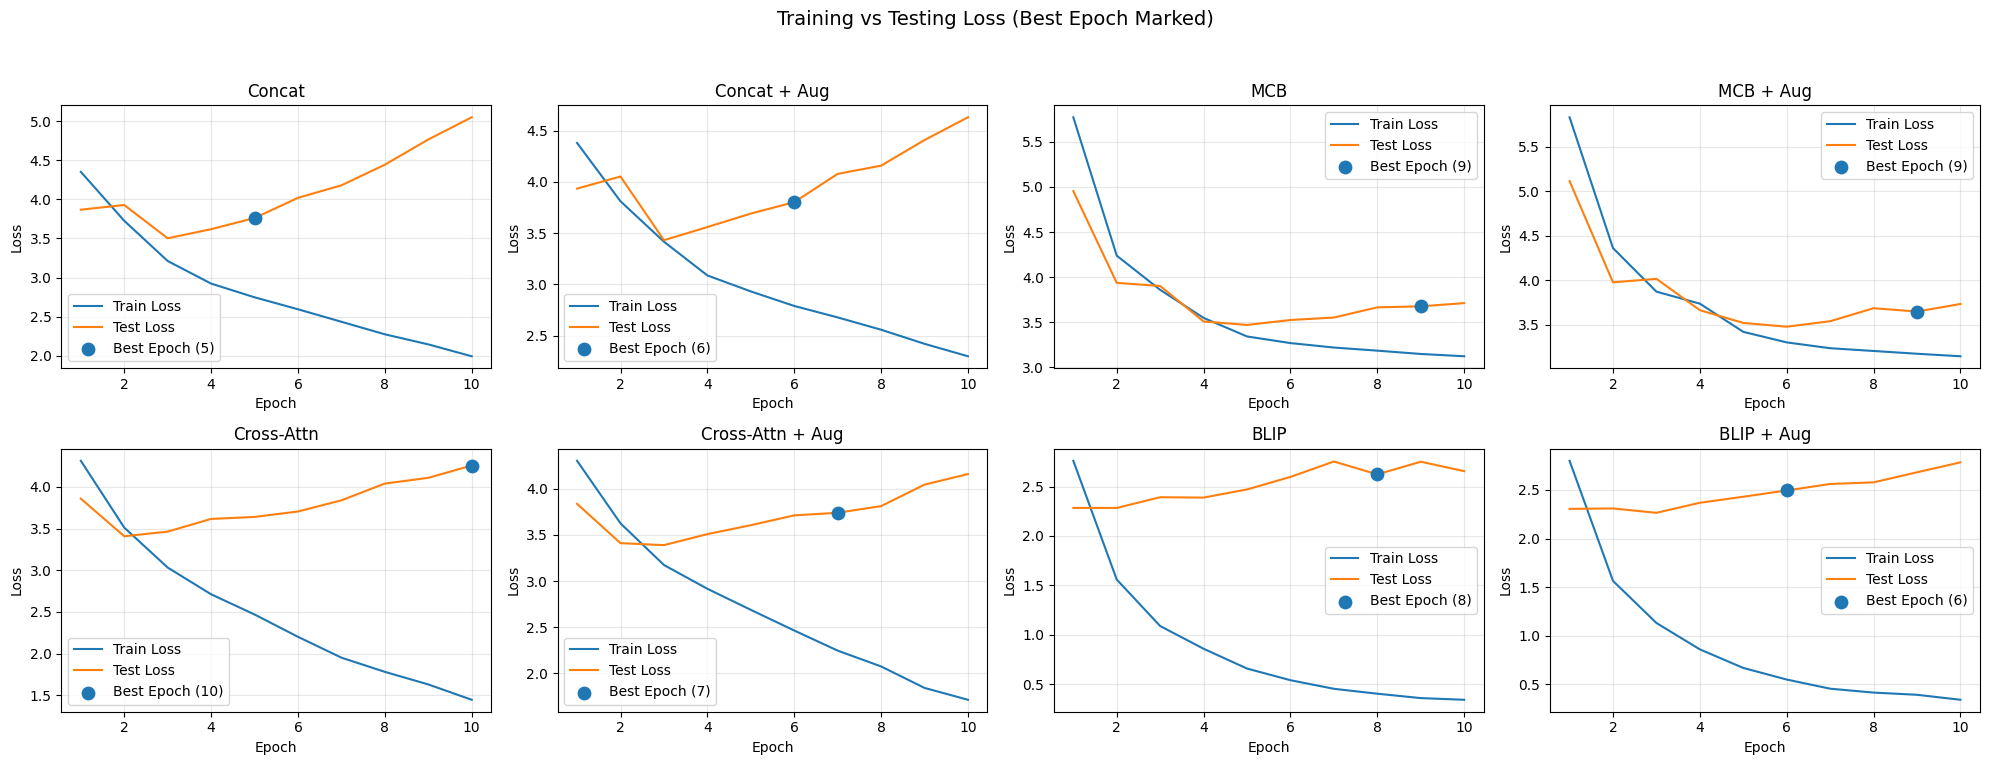

In [34]:
def plot_loss_curves_with_best(
    histories,
    model_names,
    best_epochs,
    title="Training vs Testing Loss"
):
    plt.figure(figsize=(20, 8))

    for i, (hist, name) in enumerate(zip(histories, model_names), 1):
        epochs = range(1, len(hist["train_loss"]) + 1)

        plt.subplot(2, 4, i)
        plt.plot(epochs, hist["train_loss"], label="Train Loss")
        plt.plot(epochs, hist["test_loss"], label="Test Loss")

        # ---- mark best epoch (marker on test loss curve) ----
        if name in best_epochs:
            be = best_epochs[name]
            if 1 <= be <= len(hist["test_loss"]):
                plt.scatter(
                    be,
                    hist["test_loss"][be - 1],
                    s=80,
                    zorder=5,
                    label=f"Best Epoch ({be})"
                )

        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(name)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# ✅ Call it
plot_loss_curves_with_best(
    histories=[
        history_concat,
        history_concat_aug,
        history_mcb,
        history_mcb_aug,
        history_attn,
        history_attn_aug,
        history_blip,
        history_blip_aug,
    ],
    model_names=[
        "Concat",
        "Concat + Aug",
        "MCB",
        "MCB + Aug",
        "Cross-Attn",
        "Cross-Attn + Aug",
        "BLIP",
        "BLIP + Aug",
    ],
    best_epochs=best_epochs,
    title="Training vs Testing Loss (Best Epoch Marked)",
)

Fine-tuning

In [37]:
def print_blip_qkv_modules(model, keyword="qkv", max_print=80):
    c = 0
    for n, _ in model.named_modules():
        if keyword in n:
            print(n)
            c += 1
            if c >= max_print:
                break

def load_aug_blip_best_and_add_lora(
    aug_blip_best_dir,  # e.g. BLIP_AUG_BASELINE_DIR + "/best"
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=("qkv",),  # safe default for BLIP
):
    processor = BlipProcessor.from_pretrained(aug_blip_best_dir)
    base = BlipForQuestionAnswering.from_pretrained(aug_blip_best_dir)

    lora_cfg = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        r=r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        bias="none",
        target_modules=list(target_modules),
    )

    lora_model = get_peft_model(base, lora_cfg).to(device)
    lora_model.print_trainable_parameters()

    return processor, lora_model

def train_eval_blip_lora_phase2_best(
    save_dir,
    aug_blip_best_dir,       # <-- load Aug+BLIP best from here
    train_loader,
    test_loader,
    epochs=8,
    lr=3e-5,
    max_new_tokens=10,
    model_name="Phase2: Aug+BLIP(best) + LoRA",
    resume=False,
    w_closed=0.5,
    w_open=0.5,
):
    os.makedirs(save_dir, exist_ok=True)
    best_dir = os.path.join(save_dir, "best")
    os.makedirs(best_dir, exist_ok=True)

    adapter_cfg = os.path.join(save_dir, "adapter_config.json")

    # ===== Load model =====
    if resume and os.path.exists(adapter_cfg):
        print(f"[{model_name}] Resuming LoRA adapter from: {save_dir}")
        processor = BlipProcessor.from_pretrained(save_dir)

        # load base from aug_blip_best_dir, then load adapter from save_dir
        base = BlipForQuestionAnswering.from_pretrained(aug_blip_best_dir)
        model = PeftModel.from_pretrained(base, save_dir).to(device)
    else:
        processor, model = load_aug_blip_best_and_add_lora(aug_blip_best_dir)
        processor.save_pretrained(save_dir)

    # ===== Critical: ensure LoRA params are trainable =====
    model.train()
    if hasattr(model, "set_adapter"):
        model.set_adapter("default")

    for n, p in model.named_parameters():
        if "lora_" in n:
            p.requires_grad = True

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    if len(trainable_params) == 0:
        raise RuntimeError("No trainable parameters found. LoRA adapter not enabled.")

    optimizer = torch.optim.AdamW(trainable_params, lr=lr)

    # Use underlying BLIP forward/generate (PEFT wrapper forward can be tricky for BLIP-VQA)
    core_model = model.base_model.model

    history = {
        "train_loss": [],
        "test_loss": [],
        "val_closed_acc": [],
        "val_open_bleu1": [],
        "val_open_bleu1_crit": [],
        "val_score": [],
    }

    best_epoch = 1
    best_score = -1e9

    for ep in range(1, epochs + 1):
        # ===== Train =====
        model.train()
        train_loss_sum = 0.0

        for batch in train_loader:
            batch_gpu = {k: v.to(device) for k, v in batch.items() if k != "gt_answer"}
            optimizer.zero_grad()

            out = core_model(
                input_ids=batch_gpu["input_ids"],
                attention_mask=batch_gpu["attention_mask"],
                pixel_values=batch_gpu["pixel_values"],
                decoder_input_ids=batch_gpu["decoder_input_ids"],
                labels=batch_gpu["labels"],
            )
            loss = out.loss
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()

        train_loss = train_loss_sum / max(len(train_loader), 1)
        history["train_loss"].append(train_loss)

        # ===== Test loss =====
        model.eval()
        test_loss_sum = 0.0
        with torch.no_grad():
            for batch in test_loader:
                batch_gpu = {k: v.to(device) for k, v in batch.items() if k != "gt_answer"}
                out = core_model(
                    input_ids=batch_gpu["input_ids"],
                    attention_mask=batch_gpu["attention_mask"],
                    pixel_values=batch_gpu["pixel_values"],
                    decoder_input_ids=batch_gpu["decoder_input_ids"],
                    labels=batch_gpu["labels"],
                )
                test_loss_sum += out.loss.item()

        test_loss = test_loss_sum / max(len(test_loader), 1)
        history["test_loss"].append(test_loss)

        # ===== Metrics (generation) =====
        gt_all, pred_all = [], []
        with torch.no_grad():
            for batch in test_loader:
                gt_all.extend(batch["gt_answer"])
                gen_inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "pixel_values": batch["pixel_values"].to(device),
                }
                out_ids = core_model.generate(**gen_inputs, max_new_tokens=max_new_tokens)
                preds = processor.batch_decode(out_ids, skip_special_tokens=True)
                pred_all.extend(preds)

        metrics = eval_closed_open(gt_all, pred_all)
        score = w_closed * metrics["closed_acc"] + w_open * metrics["open_bleu1_crit"]

        history["val_closed_acc"].append(metrics["closed_acc"])
        history["val_open_bleu1"].append(metrics["open_bleu1"])
        history["val_open_bleu1_crit"].append(metrics["open_bleu1_crit"])
        history["val_score"].append(score)

        print(
            f"[{model_name}] Epoch {ep}/{epochs} | Train {train_loss:.4f} | Test {test_loss:.4f} | "
            f"closed {metrics['closed_acc']:.3f} | openCrit {metrics['open_bleu1_crit']:.3f} | score {score:.3f}"
        )

        # ===== Save latest adapter =====
        model.save_pretrained(save_dir)
        processor.save_pretrained(save_dir)

        # ===== Save best adapter =====
        if score > best_score:
            best_score = score
            best_epoch = ep
            if os.path.exists(best_dir):
                shutil.rmtree(best_dir)
            model.save_pretrained(best_dir)
            processor.save_pretrained(best_dir)

    # ===== Reload best adapter and final metrics =====
    processor = BlipProcessor.from_pretrained(best_dir)
    base = BlipForQuestionAnswering.from_pretrained(aug_blip_best_dir)
    model = PeftModel.from_pretrained(base, best_dir).to(device)
    core_model = model.base_model.model

    gt_all, pred_all = [], []
    with torch.no_grad():
        for batch in test_loader:
            gt_all.extend(batch["gt_answer"])
            gen_inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "pixel_values": batch["pixel_values"].to(device),
            }
            out_ids = core_model.generate(**gen_inputs, max_new_tokens=max_new_tokens)
            preds = processor.batch_decode(out_ids, skip_special_tokens=True)
            pred_all.extend(preds)

    metrics_best = eval_closed_open(gt_all, pred_all)
    return history, metrics_best, best_epoch, best_score, best_dir

AUG_BLIP_BEST_DIR = os.path.join(PROJECT_DIR, "checkpoints", "blip_aug_baseline", "best")
PHASE2_LORA_DIR = os.path.join(PROJECT_DIR, "checkpoints", "blip_aug_lora_phase2")
os.makedirs(PHASE2_LORA_DIR, exist_ok=True)

LORA_EPOCHS = 8
LORA_LR = 3e-5  # good starting point

history_phase2_lora, metrics_phase2_lora, be_phase2, bs_phase2, best_dir_phase2 = train_eval_blip_lora_phase2_best(
    save_dir=PHASE2_LORA_DIR,
    aug_blip_best_dir=AUG_BLIP_BEST_DIR,
    train_loader=blip_train_loader_aug,
    test_loader=blip_test_loader,
    epochs=LORA_EPOCHS,
    lr=LORA_LR,
    max_new_tokens=10,
    model_name="Phase2: Aug+BLIP(best) + LoRA",
    resume=False
)

print("Phase2 LoRA best epoch:", be_phase2)
print("Phase2 LoRA best dir:", best_dir_phase2)
print(metrics_phase2_lora)

trainable params: 294,912 || all params: 361,525,052 || trainable%: 0.0816
[Phase2: Aug+BLIP(best) + LoRA] Epoch 1/8 | Train 0.4160 | Test 2.4902 | closed 0.673 | openCrit 0.214 | score 0.444
[Phase2: Aug+BLIP(best) + LoRA] Epoch 2/8 | Train 0.3997 | Test 2.4756 | closed 0.649 | openCrit 0.218 | score 0.434
[Phase2: Aug+BLIP(best) + LoRA] Epoch 3/8 | Train 0.3741 | Test 2.4488 | closed 0.637 | openCrit 0.225 | score 0.431
[Phase2: Aug+BLIP(best) + LoRA] Epoch 4/8 | Train 0.3623 | Test 2.4555 | closed 0.641 | openCrit 0.229 | score 0.435
[Phase2: Aug+BLIP(best) + LoRA] Epoch 5/8 | Train 0.3542 | Test 2.4540 | closed 0.645 | openCrit 0.230 | score 0.438
[Phase2: Aug+BLIP(best) + LoRA] Epoch 6/8 | Train 0.3489 | Test 2.4573 | closed 0.649 | openCrit 0.220 | score 0.435
[Phase2: Aug+BLIP(best) + LoRA] Epoch 7/8 | Train 0.3567 | Test 2.4618 | closed 0.645 | openCrit 0.219 | score 0.432
[Phase2: Aug+BLIP(best) + LoRA] Epoch 8/8 | Train 0.3518 | Test 2.4441 | closed 0.649 | openCrit 0.235 | s